# Red Neuronal en PyTorch

En este notebook veremos como crear una red neuronal usando PyTorch

In [1]:
# Primero llamamos a los paquetes necesarios
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

## Dataset

Ahora lo que necesitamos es un conjunto de datos (dataset). Afortunadamente el paquete **torchvision** provee un conjunto de datos de ejemplo. Utilizaremos MNIST, el cual contiene ejemplos de letras escritas a mano. El siguiente código lee el conjunto de datos y lo separa en un conjunto de entrenamiendo y uno de prueba. 

In [2]:
# Generaramos una transformación para normalizar el conjunto de datos
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Descargamos el conjunto de datos de entrenamiento
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# Cargamos el conjunto
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Descargamos y cargamos el conjunto de prueba
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Ordenamos los datos para tener parejas de imagenes con su respectiva clase

# Los datos se encuentran en trainloader asi que generamos un iterador para extraerlos uno por uno
dataiter = iter(trainloader)
images, labels = dataiter.next()

Es recomendable verificar que estamos cargando bien el conjunto de datos.

torch.Size([1, 28, 28])

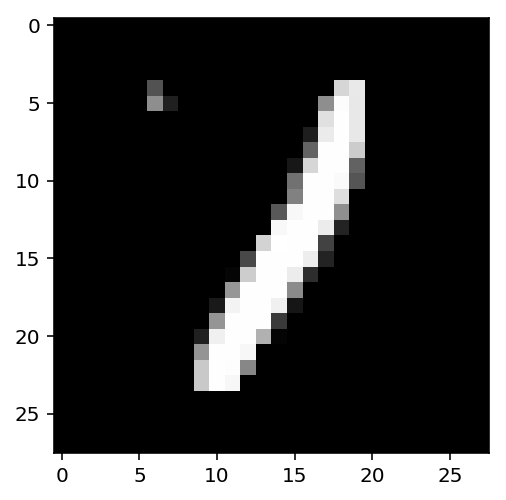

In [4]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');
images[1].size()

# Creación de la red neuronal

Ahora pasaremos a la creación de la red neuronal, como ejemplo utilizaremos una red completamente conectada (fully connected) para clasificar las imagenes de MNIST. Como entrada tendremos 784 nodos = 28 * 28, en seguida tendremos una capa oculta de 128 nodos, con una función de activación tipo RELU, despúes tendremos una segunda capa oculta con 64 nodos y función de activación RELU, en seguida tendremos 10 nodos de salida los cuales pasan por una función softmax que convierte los valores a probabilidades. Finalmente calculamos la pérdida (loss) con la función de entropía cruzada. 

<img src="archivos/net.png">

El modulo que contiene las herramientas para crear la RN es **pytorch.nn**. La red neuronal en sí se crea como una clase que hereda la estructura de **pytorch.nn.Module**. Cada una de las capas de la red se define de forma independiente. e.g. Para crear una capa con 784 entradas y 128 nodos utilizamos *nn.Linear(784, 128)*

La red implementa la función *forward* que realiza el paso frontal (fowdward pass). Esta función miembro recibe un tensor como emtrada y calcula la salida de la red. 

Varias funciones de activación se encuntran en el módulo *nn.functional*. Dicho módulo usualmente se importa como *F*. 


In [5]:
# importamos

from torch import nn
from torch import optim
import torch.nn.functional as F

In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Definir las capas. Cada una con 128, 64 y 10 unidades respectivamente
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Capa de salida con 10 units (una para cada dígito)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Pase frontal de la red, regresamos las probabilidades '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Inicializamos pesos y sesgos

Cuando creas las capas se crean también los tensores correspondientes a los pesos y sesgos. Éstos son inicializados por ti, aunque pudes modificarlos usando funciones extra. Para observar sus valores puedes llamar a *model.fc1.weight* 


In [7]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0165,  0.0076,  0.0262,  ..., -0.0338, -0.0274,  0.0004],
        [ 0.0310,  0.0161, -0.0259,  ..., -0.0172,  0.0103,  0.0138],
        [-0.0201, -0.0247,  0.0063,  ...,  0.0017,  0.0275,  0.0191],
        ...,
        [ 0.0058, -0.0259, -0.0033,  ..., -0.0011, -0.0334, -0.0328],
        [-0.0169,  0.0164,  0.0039,  ..., -0.0129,  0.0009,  0.0007],
        [-0.0331, -0.0253, -0.0105,  ...,  0.0030, -0.0121, -0.0289]],
       requires_grad=True)
Parameter containing:
tensor([-0.0286, -0.0132, -0.0294,  0.0129,  0.0172,  0.0176, -0.0137, -0.0028,
        -0.0308,  0.0054,  0.0344,  0.0027,  0.0206, -0.0282, -0.0302, -0.0214,
        -0.0215,  0.0169,  0.0319,  0.0271, -0.0082,  0.0293, -0.0207, -0.0138,
         0.0207,  0.0099, -0.0246,  0.0287, -0.0207,  0.0278,  0.0203,  0.0296,
         0.0192, -0.0218, -0.0309, -0.0350, -0.0231,  0.0013,  0.0218, -0.0105,
        -0.0304, -0.0189, -0.0113,  0.0014,  0.0071, -0.0020, -0.0005,  0.0012,
         0.0168

Supongamos que deseamos inicializar los pesos con algunos valores personalizados. Dado que los pesos y sesgos en sí son variables de autograd (optimizador) necesitamos convertirlos a tensores para poder modificarlos.

In [8]:
# Colocamos ceros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [9]:
# muestreamos de una distribución normal con media cero y desv. estandar = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0001, -0.0176, -0.0116,  ..., -0.0152, -0.0002, -0.0166],
        [-0.0048, -0.0030, -0.0006,  ..., -0.0063, -0.0022,  0.0078],
        [-0.0231,  0.0069,  0.0086,  ...,  0.0260,  0.0083, -0.0059],
        ...,
        [-0.0105, -0.0006, -0.0041,  ...,  0.0047, -0.0003,  0.0081],
        [-0.0018, -0.0046, -0.0135,  ..., -0.0140, -0.0046,  0.0054],
        [-0.0112,  0.0002, -0.0001,  ...,  0.0307, -0.0051, -0.0113]])

### Pase frontal

Hasta el momento la red no está entrenada y solo tenemos los pesos aleatorios. Hagamos un pase frontal para ver que pasa. Primero debemos convertir la imagen a un tensor y pasarla a través de la red. 

In [13]:
# Obtengamos el siguiente valor 
#dataiter = iter(trainloader)
images, labels = dataiter.next()

# Reestructuremos la imagen a un vector de una dimensión, hay quie le llama a esta operación "aplanado".
# La nueva forma será (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# alternativa: images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Pase frontal de la red
img_idx = 0
ps = model.forward(images[img_idx,:])



In [20]:
ps

#img = images[img_idx]
#helper.view_classify(img.view(1, 28, 28), ps)

tensor([[0.1069, 0.1073, 0.0943, 0.1041, 0.0886, 0.0924, 0.1074, 0.1048, 0.1030,
         0.0912]], grad_fn=<SoftmaxBackward>)

Muy probablemente ninguna de las clases tiene una probabilidad grande con respecto de las otras, esto se debe a que todavía no hemos entrenado la red. En el siguiente ejercicio entrenaremos la red.
